# Python Assignment 5 part 2 by Team A 

In [ ]:
import numpy as np
import librosa
import pretty_midi
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import soundfile as sf
import librosa.display
import math
import scipy
import time
from scipy import signal

# Mixing a track in Python

In this project we have tried to mix a multitrack song using only Python and self-designed FX and tools. We made five tracks of unprocessed audio (Programmed in midi in Cubase 11), and load them into this program to process each of the tracks and then sum together for a final mix. Obviously Python is not a very good option for mixing a song, but we thought it was an interesting challenge and a way to really push all we have learned about signal processing so far this term. 

The original unprocessed total of the music can be heard in the cell below. 
In the end of this assignment we display the waveforms in the style of both Audacity and Serato/Traktor. 


In [ ]:
sr = 48000

org_mix, r3 = librosa.load('audio/py5-fullmix.wav', sr=sr)
ipd.Audio(org_mix, rate=48000)

### Loading the tracks

In [ ]:
# Importing audio file

s, r = librosa.load('audio/py5-Hihats and toms.wav', sr=sr)
s2, r2 = librosa.load('audio/py5-Main drums.wav', sr=sr)
s3, r5 = librosa.load('audio/py5-Pluck synth.wav', sr=sr)
brass, r3 = librosa.load('audio/py5-Brass stabs.wav', sr=sr)
bass, r4 = librosa.load('audio/py5-Bass synth.wav', sr=sr)

### Functions

Here are the functions needed to run the program. The first cell contains the functions we use to slice, pad and stitch together the audio in the processing part of the program.

In [ ]:
# Function to add fadeins and fadeouts to the segments to avoid clicks
def fade(segment, fadesize):
    fades = np.array([])
    fadesize = fadesize
    if segment.size <= (fadesize*2):
        fadesize = int(segment.size / 10)
        midpart = np.ones(segment.size - (int(fadesize*2)))
        fadein = np.linspace(0,1,num=fadesize)
        fadeout = np.linspace(1,0,num=fadesize)
        fades = np.concatenate((fadein, midpart, fadeout))
        
    else:         
        midpart = np.ones(segment.size - (int(fadesize*2)))   
        fadein = np.linspace(0,1,num=fadesize)
        fadeout = np.linspace(1,0,num=fadesize)
        fades = np.concatenate((fadein, midpart, fadeout))
        
    y = segment * fades
    
    return y

# Function to check if a segment has the correct size, and if not to make sure it is right
# by padding or deleting samples. 
def sizecheck(segment, result):
    if segment.size != result.size:
        if segment.size > result.size:
            diff = segment.size-result.size            
            segment = np.delete(segment_final, diff)
            
        elif result.size > segment.size:
            zeros= np.zeros(result.size - segment.size)
            
            segment = np.concatenate((segment, zeros))
    else:
        pass
    
    return segment

# Main function to zeropad a segment before we paste it back into the final result
def padder(segment, audiototal, current_beat):
    y = np.pad(segment, [current_beat, audiototal.size-(current_beat+segment.size)])
    return y

# Function to overlap segments. Cutting a small part in the beginning
# and apply padding equal to the overlap in the end
def overlapper(segment, overlap):
    x = segment[overlap:segment.size]
    y = np.pad(x, [0, overlap])
    return y

### FX Functions
We made a lot of different FX that we use in the processing of the individual tracks. 

In [ ]:
"""FX processing functions"""

def compressor(audio, threshold, makeup, smoothness):
    x = np.array([])
    x = np.append(x, audio)
    for i in range(smoothness):
        index = 0        
        for i in x:        
            if np.abs(i) >= threshold + 0.3:
                x[index] = i * 0.85                 
            elif np.abs(i) >= threshold + 0.2:
                x[index] = i * 0.90            
            elif np.abs(i) >= threshold + 0.1:
                x[index] = i * 0.95            
            elif np.abs(i) >= threshold:
                x[index] = i * 0.99            
            else:
                x[index] = i
            index += 1
            
    y = x * (1+makeup)
    
    return y

def IRDelay(audio, impulses, sr=sr):
    s = np.pad(audio, [0, audio.size])
    s = fade(s, 1024)
    
    impulse_array = np.linspace(0.2, 0, num=impulses)
    IRarray = np.array([])
    size = int(s.size/impulses)-1
    for i in range(impulses):

        IRarray = np.append(IRarray, np.zeros(size))
        IRarray = np.append(IRarray, impulse_array[i])

    IRarray = sizecheck(IRarray, s)

# transform to frequency domain
    Y = scipy.fft.fft(s)
    H = scipy.fft.fft(IRarray)

# Doing the convolution in the frequency domain 
    output = Y*H

# back to time domain
    output = np.real(scipy.fft.ifft(output))
    return output


def allpass(delay, gain):
    b = np.zeros(delay)
    b[0] = gain
    b[delay-1] = 1
    a = np.zeros(delay)
    a[0] = 1
    a[delay-1] = gain
    return b,a


def IIRReverb(audio, combq, delay1, gain1, delay2, gain2):
    
    """A Schroeder reverb with four parallell comb filters and two cascading allpass filters.
    audio = the audio that you will apply the reverb on
    combq = Q factor of the comb filters. Play around but 20 is a good place to start
    delay1 = the delay of the first allpass filter, try settings around 1000
    gain1 = the gain of the first allpass, try anything between 0 and 1, closer to 1 
    results in more volume in the reverb
    delay2 = same as delay1 but for the second allpass filter. Try a different and slightly longer
    value than delay1, for example 3500
    gain2 = same as gain1 but for the second allpass filter"""
    
    s_tail = audio
    s_tail = np.append(s_tail, np.zeros(audio.size))    
    
    # First comb filter
    f0 = 200  
    Q = combq  
    b1,a1 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y1 = signal.lfilter(b1,a1,s_tail)
    # Second comb filter 
    f0 = 300  
    Q = combq  
    b2,a2 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y2 = signal.lfilter(b2,a2,s_tail)
    # Third comb filter
    f0 = 400  
    Q = combq  
    b3,a3 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y3 = signal.lfilter(b3,a3,s_tail)
    # Fourth comb filter
    f0 = 500 
    Q = combq  
    b4,a4 = signal.iircomb(f0, Q, ftype='notch', fs=sr)
    y4 = signal.lfilter(b4,a4,s_tail)
    # computing up the parallell structure by adding them together (and scaling the amplitude)
    comb_result = (y1 + y2 + y3 + y4)*0.2
    # Designing the two allpass filters
    b1,a1 = allpass(delay1, gain1)
    b2,a2 = allpass(delay2, gain2)

    # Convolving the coefficients to get the cascading structure
    cascade_a = np.convolve(a1,a2)
    cascade_b = np.convolve(b1,b2)

    # Run the result from the comb parallell filters through the cascade of allpass filters
    signal_output = signal.lfilter(cascade_b, cascade_a, comb_result)
    # Merging wet with dry
    #audio = np.append(audio, np.zeros([signal_output.size-audio.size]))
    #output = ((signal_output * wet)+audio)*0.5
    
    
    return signal_output


def framecompressor(audio, frame_length, threshold, ratio, makeup):
    
    """audio = audio to be compressed
    frame_length = compression window, try 2048
    threshold = what value of amplitude will cause the compressor to compress, try 0.3
    ratio = a float from 0 to 1, 0 will result in total gainremoval in the middle
    of the compressor window and 1 will result in no compression. 
    makeup = how much you multiply the audio with after compression. Try 1.1 or 1.2
    
    """
    window = signal.get_window('hann', frame_length)    
    b = np.array([-ratio])
    c = signal.convolve(window, b)
    window = c + 1
    
    x = np.array([])
    x = np.append(x, audio)
    
    for i in range(0, len(audio), int(frame_length*0.5)):
                
        s = x[i:i + frame_length]        
        a = np.max(np.abs(s))
        if a > threshold:            
            s = s * window
            x[i:i+frame_length] = s
        
    compressed = x * makeup
    return compressed

def reverse(audio):
    s = np.flip(audio)
    return s


def softClipper(audio, drive, output=0.8):

    """audio = Source to be SoftClipped
    drive = Amount of SoftClipping (Try between 10-40)
    output = Output volume
    
    The signal is normalized before output attenuation for better control.
    """
    
    # Drive can not be set to 0
    if drive == 0:
        drive = 1
    
    piDivisor = 2 / np.pi
    driver = np.arctan(audio * drive)
    
    softclip = piDivisor * driver
    
    #normalized = softclip/np.max(softclip)
    softClipped = softclip * output
    
    return softClipped

def FIR_fft(audio, order, passband_hz, stopband_hz, pass_zero='lowpass', sr=sr):
    
    numtaps = order-1 # filter length (or number of tabs)
    
    wp = passband_hz/(sr/2) # passband edge normalized frequency
    ws = stopband_hz/(sr/2) # stopband edge normalized frequency

    freqs = [0.0, wp, ws, 1.0]
    
    if pass_zero == 'lowpass':
        gains = [1.0, 1.0, 0.0, 0.0] # normalized gain values (0.5 = -3 dB)
    elif pass_zero == 'highpass':
        gains = [0.0, 0.0, 1.0, 1.0] # normalized gain values (0.5 = -3 dB)
                
    # Compute the FIR filter coefficients 
    h = signal.firwin2(numtaps, freqs, gains, window='hann') # compute FIR coefficients using firwin2 function
    
    # Design the FIR filter in the frequency domain 
    h_padded = np.pad(h,[0,len(audio)-len(h)]) # pad FIR coefficients with zeros in order to match the signal length
    
    # Apply the discrete Fourier Transform to the FIR filter (move to the frequency domain)
    X = scipy.fft.fft(audio)
    H = scipy.fft.fft(h_padded)
    
    Y = X*H # do the product of the DFT of the signal with the padded filter impulse response
    
    # Apply the inverse discrete Fourier Transform to the FIR filter (back to the time domain)
    y = np.real(scipy.fft.ifft(Y))
        
    return y #signal filtered in the frequency domain

### Functions to resynthesize
We made some different signal creating functions that could be used to resynthesize based on the midi information. 

In [ ]:
def sawtooth_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp * signal.sawtooth(2 *np.pi*freq*t*phase)

    return s

def triangle_synth(freq, dur_ms, sr=sr, amp=1, phase=1, width=0.5):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp * signal.sawtooth(2 *np.pi*freq*t*phase)

    return s

def sine_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp*np.sin(2*np.pi*freq*t*phase)
    
    return s
    

def square_synth(freq, dur_ms, sr=sr, amp=1, phase=1):
    t = np.arange(0, dur_ms/1000, 1/sr)
    s = amp*signal.square(2*np.pi*freq*t*phase)
    
    return s


# Repurposing the sine_synth as a LFO (for PWM).
def myLFO(lfo_hz, dur_ms, lfo_depth):
    if lfo_depth < 0.01:
        lfo_depth = 0.01
    elif lfo_depth > 0.99:
        lfo_depth = 0.99
    lfo = sine_synth(lfo_hz, dur_ms, amp=lfo_depth)
    
    return lfo


def myPWM(freq, lfo_hz, dur_ms, lfo_depth=0.9):
    t = np.linspace(0, 1, sr*(int(dur_ms/1000)), endpoint=False)
    lfo = myLFO(lfo_hz, dur_ms, lfo_depth)
    pwm = signal.square(2 * np.pi * freq * t, duty=(lfo + 1)/4)
    
    return pwm


def chirp_sound(freq_start, freq_end, dur_ms, amp=1):
    
    t = np.arange(0, int((dur_ms/1000)*sr)) / sr
    s = amp * signal.chirp(t, f0=freq_start, f1=freq_end, t1=dur_ms/1000, method='linear')

    return s

# Multiply the amp_envelope with your generated signal note by note 
# to get a nice smooth attack and decay

def amp_envelope(dur_ms, sr=sr):
    
    t = np.arange(0, dur_ms/1000, 1/sr)
    
    # Splitting t up into 4 parts
    attack_length = int(len(t) / 20)
    decay_length = int(len(t) / 4)
    sustain_length = int(len(t) / 2)
    release_length = int(len(t) - (attack_length + decay_length + sustain_length))
    
    # Setting the start and stop amplitube values for the ramps
    attack = np.linspace(0, 0.9, num=attack_length)
    decay = np.linspace(0.9, 0.75, num=decay_length)
    sustain = np.linspace(0.75, 0.6, num=sustain_length)
    release = np.linspace(0.6, 0, num=release_length)
    
    # Putting them together in order
    env = np.concatenate((attack, decay, sustain, release))
    
    return env

---

### Midi
Loading Midi and extracting information from the midi file. 

In [ ]:
#loading midi and displaying info

pm = pretty_midi.PrettyMIDI('audio/py5.midi')

In [ ]:
# Creating a list based on the downbeats
downbeats_in_seconds = pm.get_downbeats()

# Converting it to sample positions
downbeats_sample_time = downbeats_in_seconds*48000
downbeats_sample_time = downbeats_sample_time. astype(int)
downbeats_sample_time = downbeats_sample_time[1:]

# Mixing each track
Here is each track going through it's own mixing/processing process. In the end of each track's cell we will display the waveplot of the original and the new track. There's also a small audio widget for listening to the mixed track. Each main block of code takes time to run, so have patience. 

### Hi hat track mixing
Mixing the first drum track with hi hats and toms. Alternating between reverb, delay and reversed audio to create some movement.  

In [ ]:
# Have patience, it takes some time

# Creating the result array we will add all signals back into
result = np.zeros(s.size) 

# Temporary arrays used in the for loop
segment = np.array([])
seg = np.array([])

# Setting parameters for the loop
counter = 0
current_beat = 0
overlap = 0
overlap_length = 1024


for i in downbeats_sample_time:
    # To check computational time and where it struggles, uncomment print(i). 
    #print(i)
    
    counter += 1
    
    # Slicing the segment from current_beat to the sample position i
    seg = s[current_beat:i]    
    # adding fade ins and outs to the segment
    segment = fade(seg, overlap_length)
    
    # Processing segments one by one with different FX and signal processing
    if counter == 1:
        
        segment = compressor(segment, 0.3, 1, 1)
        seg_fx = IRDelay(segment, 8)
        segment_padded = padder(segment, s, current_beat)
        segment_fx = padder(seg_fx, s, current_beat)
          
        segment_padded = (segment_padded + segment_fx)
                
    elif counter == 2:
        segment = compressor(segment, 0.3, 1, 1)
        segment = softClipper(segment, 7)
        segment_padded = padder(segment, s, current_beat)
        
    elif counter == 3:
        segment = compressor(segment, 0.3, 1, 1)
        seg_fx = IIRReverb(segment, 20, 800, 0.78, 1700, 0.68)
        segment_padded = padder(segment, s, current_beat) 
        segment_fx = padder(seg_fx, s, current_beat)
          
        segment_padded = (segment_padded + segment_fx)

    elif counter == 4: 

        segment = compressor(segment, 0.3, 1, 1)
        segment = reverse(segment)
        segment_padded = padder(segment, s, current_beat)
    
    # updating the current beat for the next loop
    current_beat = current_beat + seg.size    
    segment_overlapped = segment_padded[overlap:segment_padded.size]
    
    # getting the size right again by adding zeros to the end:
    segment_final = np.pad(segment_overlapped, [0, overlap])

    # Increasing overlap for next round of for loop 
    overlap = overlap + overlap_length
    
    # Just making sure the sizes are allright 
    segment_final = sizecheck(segment_final, result)
    
    # Resetting the counter when it reaches 4
    if counter == 4:
        counter = 0
    # pasting the segments back in, one by one
    result = result + segment_final


# Plotting the original track compared to the result after mixing it
plt.figure(figsize=(8, 4))
plt.subplot(2,1,1)
librosa.display.waveplot(s, sr=sr)
plt.subplot(2,1,2)
librosa.display.waveplot(result, sr=sr)
plt.show()
hihats = result

ipd.display(ipd.Audio(s, rate=sr))
ipd.display(ipd.Audio(hihats, rate=sr))

### Main drums mixing
Mixing the kick and snare drum track. Applying a moving low pass filter in the beginning, then opening it up. The drums are compressed as well. Adding a low downward frequency sweep for flavour on the third beat of every measure. 

In [ ]:
# Creating the result array we will add all signals back into
result = np.zeros(s.size) 

# Temporary arrays used in the for loop
segment = np.array([])
seg = np.array([])

# Setting parameters for the loop
counter = 0
current_beat = 0
overlap = 0
overlap_length = 1024

passband = 100
stopband = 150

chirpseg = np.zeros(s2.size)
chirpsound = chirp_sound(65, 261, 850, amp=0.1)

for i in downbeats_sample_time:
    # Uncomment to check computational time
    #print(i)
    counter += 1
    
    # Slicing the segment from current_beat to the sample position i
    seg = s2[current_beat:i]    
    # adding fade ins and outs to the segment
    segment = fade(seg, overlap_length)
    # Adding some synthesized audio to the beat   
    if np.max(seg) > 0.2:         
        chirpsound = fade(chirpsound, overlap_length)            
        chirpseg[current_beat+57090:current_beat+57090+chirpsound.size] = chirpsound    
    

    # Processing with compressor
    segment = framecompressor(segment, 2048, 0.6, 0.75, 1.2)
    if counter < 10:
        
        segment = FIR_fft(segment, 9, passband, stopband, pass_zero='lowpass', sr=sr) 
        
        passband += 100
        stopband += 100
            
    segment_padded = padder(segment, s2, current_beat)
    
    segment_padded = segment_padded + (chirpseg*0.2)
    
    # updating the current beat for the next loop
    current_beat = current_beat + seg.size    
    segment_overlapped = segment_padded[overlap:segment_padded.size]
    
    # getting the size right again by adding zeros to the end:
    segment_final = np.pad(segment_overlapped, [0, overlap])

    # Increasing overlap for next round of for loop 
    overlap = overlap + overlap_length
    
    # Just making sure the sizes are allright 
    segment_final = sizecheck(segment_final, result)
    
    
    # pasting the segments back in, one by one
    result = result + segment_final

# Plotting the original track compared to the result after mixing it
plt.figure(figsize=(8, 4))
plt.subplot(2,1,1)
librosa.display.waveplot(s2, sr=sr)
plt.subplot(2,1,2)
librosa.display.waveplot(result, sr=sr)
plt.show() 
drums = result
ipd.display(ipd.Audio(s2, rate=sr))
ipd.display(ipd.Audio(drums, rate=sr))

### Pluck Synth mixing
Mixing the pluck synth track. Adding reverb and saturation, and a moving low pass filter.
Delay in the end to make it more interesting. 

In [ ]:
# Creating the result array we will add all signals back into
result = np.zeros(s.size) 

# Temporary arrays used in the for loop
segment = np.array([])
seg = np.array([])

# Setting parameters for the loop
counter = 0
current_beat = 0
overlap = 0
overlap_length = 1024
stopband = 550
passband = 450

for i in downbeats_sample_time:
    # To check computational time and where it struggles, uncomment print(i). 
    # print(i)
    
    counter += 1
    
    # Slicing the segment from current_beat to the sample position i
    seg = s3[current_beat:i]    
    # adding fade ins and outs to the segment
    segment = fade(seg, overlap_length)
    
    # Processing segments one by one with different FX and signal processing
    if counter < 5:
        # silencing it
        segment = segment * 0
        segment_padded = padder(segment, s3, current_beat)
                                  
    elif counter >= 18:
        segment = IIRReverb(segment, 20, 1000, 0.78, 4200, 0.68)
        segment = softClipper(segment, 23)
        segmentFX = IRDelay(segment, 8)
        segment_padded = padder(segment, s3, current_beat)
        segmentFX_padded = padder(segmentFX, s3, current_beat)
        segment_padded = (segment_padded + segmentFX_padded) * 0.5

    elif counter >= 5:
        segment = IIRReverb(segment, 20, 1000, 0.78, 4200, 0.68)
        segment = softClipper(segment, 23)
        segment = FIR_fft(segment, 21, passband, stopband, pass_zero='lowpass', sr=sr) 
        stopband += 100
        passband += 100
        #segment = segment * 0.5        
        segment_padded = padder(segment, s3, current_beat)
    
    # updating the current beat for the next loop
    current_beat = current_beat + seg.size    
    segment_overlapped = segment_padded[overlap:segment_padded.size]
    
    # getting the size right again by adding zeros to the end:
    segment_final = np.pad(segment_overlapped, [0, overlap])

    # Increasing overlap for next round of for loop 
    overlap = overlap + overlap_length
    
    # Just making sure the sizes are allright 
    segment_final = sizecheck(segment_final, result)
    
    
    # pasting the segments back in, one by one
    result = result + segment_final

# Plotting the original track compared to the result after mixing it
plt.figure(figsize=(8, 4))
plt.subplot(2,1,1)
librosa.display.waveplot(s3, sr=sr)
plt.subplot(2,1,2)
librosa.display.waveplot(result, sr=sr)
plt.show()
pluck_synth = result
ipd.display(ipd.Audio(s3, rate=sr))
ipd.display(ipd.Audio(pluck_synth, rate=sr))

# Resynthesizing the Pluck synth part 
The pluck synth needed some magic, so it is resynthesized here. 
We use it to have two different pluck synths playing in left and right in the final mix. 
Time did not enable us to actually resynthesize it with any of our signal creating functions but we will certainly try that for the portifolio. 

In [ ]:
# Midi again

# Extracting the right instrument
plucksynth = pm.instruments[2]
# Resynthesizing the midi using pretty_midis function
resynthed = plucksynth.synthesize(fs=48000, wave=signal.square)
# Applying saturation, reverb and filter
resynthed = softClipper(resynthed, 23)
resynthed = IIRReverb(resynthed, 20, 1000, 0.78, 4200, 0.68)
resynthed = FIR_fft(resynthed, 21, 800, 1300, pass_zero='lowpass', sr=sr)

resynthed_plucks = resynthed[0:s3.size]

# Mixing the brass stabs 
Adding filtering, a moving delay and even reversing the track every fourth measure. 

In [ ]:
# BRASS STABS MIXING

# Creating the result array where all signals will be added into
result = np.zeros(brass.size) 

# Temporary arrays used in the for loop
segment = np.array([])
seg = np.array([])

# Making the counter
counter = 0
current_beat = 0
overlap = 0
overlap_length = 1024

# Arguments' initial values
 # Frame compressor
frame_length = 2048
threshold = 0.3
ratio = 0.4
makeup = 1.5
 # FIR fft
order = 21
passband = 400
stopband = 550
pass_zero = 'lowpass'
 # IIRReverb
combq = 40
delay1 = 1100
gain1 = 0.48
delay2 = 1500
gain2 = 0.38
 # IRDelay
impulses = 7

for i in downbeats_sample_time:
    # Uncomment to check computational time and where it struggles
    # print(i)
    
    counter += 1
    
    # Slicing the segment from current_beat to the sample position i
    seg = brass[current_beat:i]    
    # Adding fade ins and outs to the segment
    segment = fade(seg, overlap_length)
       
    if counter == 1:
       
        segment = framecompressor(segment, frame_length, threshold, ratio, makeup)
        seg_lop = FIR_fft(segment, order, passband, stopband, pass_zero=pass_zero, sr=sr) 
        segment_padded = np.pad(segment,[current_beat, brass.size-(current_beat+segment.size)]) 
        segment_lop = np.pad(seg_lop,[current_beat, brass.size-(current_beat+seg_lop.size)])

          
        segment_padded = (segment_padded + segment_lop)
        
        # Updated effects values
        passband += 50
        stopband += 50
        
    elif counter == 2:
        
        segment = reverse(segment)
        seg_lop = FIR_fft(segment, order, passband, stopband, pass_zero=pass_zero, sr=sr) 
        seg_del = IRDelay(segment, impulses, sr=sr)
        segment_padded = np.pad(segment,[current_beat, brass.size-(current_beat+segment.size)]) 
        segment_lop = np.pad(seg_lop,[current_beat, brass.size-(current_beat+seg_lop.size)])
        segment_del = np.pad(seg_del,[current_beat, brass.size-(current_beat+seg_del.size)])
        
          
        segment_padded = (segment_padded + segment_lop + segment_del)
        
        # Updated effects values
        passband += 50
        stopband += 50
        
    elif counter == 3:
        
        segment = framecompressor(segment, frame_length, threshold, ratio, makeup)
        seg_lop = FIR_fft(segment, order, passband, stopband, pass_zero=pass_zero, sr=sr)
        seg_del = IRDelay(segment, impulses+1, sr=sr)
        segment_padded = np.pad(segment,[current_beat, brass.size-(current_beat+segment.size)]) 
        segment_lop = np.pad(seg_lop,[current_beat, brass.size-(current_beat+seg_lop.size)])
        segment_del = np.pad(seg_del,[current_beat, brass.size-(current_beat+seg_del.size)])

          
        segment_padded = (segment_padded + segment_lop + segment_del)
        
       # Updated effects values
        passband += 50
        stopband += 50

    elif counter == 4: 
        
        seg_lop = FIR_fft(segment, order, passband, stopband, pass_zero=pass_zero, sr=sr)
        seg_del = IRDelay(segment, impulses+1, sr=sr)
        seg_rev = IIRReverb(segment, combq, delay1, gain1, delay2, gain2)
        segment_padded = np.pad(segment,[current_beat, brass.size-(current_beat+segment.size)])
        segment_lop = np.pad(seg_lop,[current_beat, brass.size-(current_beat+seg_lop.size)])
        segment_del = np.pad(seg_del,[current_beat, brass.size-(current_beat+seg_del.size)])
        segment_rev = np.pad(seg_rev,[current_beat, brass.size-(current_beat+seg_rev.size)])
        

        segment_padded = (segment_padded + segment_lop + segment_del + segment_rev)
        
        # Updated effects values
        passband += 50
        stopband += 50
        gain1 = 0.10
        gain2 += 0.05
    
    
    # Updating the current beat for the next loop
    current_beat = current_beat + seg.size

    
    segment_overlapped = segment_padded[overlap:segment_padded.size]
    
    # Getting the size right again by adding zeros to the end:
    segment_final = np.pad(segment_overlapped, [0, overlap])
    # Increasing overlap for next round of for loop 
    overlap = overlap + overlap_length
    
    # Just making sure the sizes are allright 
    segment_final = sizecheck(segment_final, result)
    
    # Resetting the counter when it reaches 4
    if counter == 4:
        counter = 0
    # Pasting the segments back in, one by one
    result = result + segment_final
    
# Playing back the result
ipd.display(ipd.Audio(brass, rate=sr))
ipd.display(ipd.Audio(result, rate=sr))

# Plotting the original track compared to the result after mixing it
plt.figure(figsize=(8, 4))
plt.subplot(2,1,1)
librosa.display.waveplot(brass, sr=sr)
plt.subplot(2,1,2)
librosa.display.waveplot(result, sr=sr)
plt.show()

# Re-name the result to add to the other instruments later
bras = result

# Bass synth mixing
Filtering, compressing and distorting it. Lowpass filters opens up as the song progresses. 


In [ ]:
# BASS SYNTH MIXING

# Creating the result array where all signals will be added into
result = np.zeros(bass.size) 

# Temporary arrays used in the for loop
segment = np.array([])
seg = np.array([])

# Setting variables for the loop
current_beat = 0
overlap = 0
overlap_length = 1024

# Arguments' initial values
 # Frame compressor
frame_length = 2048
threshold = 0.3
ratio = 0.6
makeup = 1.5
 # FIR fft
order = 21
passband = 60
stopband = 90
pass_zero = "lowpass"
 # IIRReverb
combq = 40
delay1 = 1100
gain1 = 0.48
delay2 = 1500
gain2 = 0.38
 # softClipper
drive = 30
output = 0.9


for i in downbeats_sample_time:
    # Uncomment to check computational time and where it struggles:
    # print(i)
    
    # Slicing the segment from current_beat to the sample position i
    seg = bass[current_beat:i]    
    # Adding fade ins and outs to the segment
    segment = fade(seg, overlap_length)
       
    
    segment = framecompressor(segment, frame_length, threshold, ratio, makeup)
    segment = FIR_fft(segment, order, passband, stopband, pass_zero=pass_zero, sr=sr)
    segment = softClipper(segment, drive, output)
    segment_padded = padder(segment, bass, current_beat)
                
    # Updated effects values
    passband += 51
    stopband += 61
            
    # Updating the current beat for the next loop
    current_beat = current_beat + seg.size
    
    segment_overlapped = segment_padded[overlap:segment_padded.size]
    
    # Getting the size right again by adding zeros to the end:
    segment_final = np.pad(segment_overlapped, [0, overlap])
    # Increasing overlap for next round of for loop 
    overlap = overlap + overlap_length
    
    # Just making sure the sizes are allright 
    segment_final = sizecheck(segment_final, result)
        
    # Pasting the segments back in, one by one
    result = result + segment_final
    
# Playing back the result
ipd.display(ipd.Audio(bass, rate=sr))
ipd.display(ipd.Audio(result, rate=sr))
result = result/np.max(result)
bas = result
plt.figure(figsize=(8, 4))
plt.subplot(2,1,1)
librosa.display.waveplot(bass, sr=sr)
plt.subplot(2,1,2)
librosa.display.waveplot(bas, sr=sr)
plt.show()

# Mixing it all together
So the challenge here is to get a mix of everything together sounding half decent. It is aestethically speaking quite lo fi, and of course no sane person would attempt to do their mix in Python with home made signal processing. But we tried! And we had fun. 





In [ ]:
# Stereo Mix

mixL = (hihats*0.5) + (drums*0.9) + (pluck_synth*0.7) + (bras*1) + (bas*0.7)
mixR = (hihats*0.5) + (drums*0.9) + (pluck_synth*0.2) + (resynthed_plucks*0.3) + (bras*0.7) + (bas*0.7)

# Normalizing the mix
mixL = mixL * 0.75
mixR = mixR * 0.75

MIX = np.array([mixL, mixR])

# Mono mix

mix = (hihats*0.4) + (drums*0.8) + (pluck_synth*0.7) + (bras) + (bas*0.7) + (resynthed_plucks*0.3)
mix = mix * 0.75

ipd.Audio(MIX, rate=sr)

In [ ]:
# Writing the mix to disk
MIX.T
sf.write('audio/stereo_file.wav', MIX.T, sr)

# Visually comparing the original to the new mix

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(2,1,1)
librosa.display.waveplot(org_mix, sr=sr)
plt.subplot(2,1,2)
librosa.display.waveplot(mix, sr=sr)
plt.show()

## Visualizations

#### Audacity (Peak + RMS)

In [ ]:
# Import features.py to access our RMS-function
import features

In [ ]:
## A function to display in the style of Audacity
def vizAudacity(audio):

    frame_length = 512
    
    # Finding the RMS
    rms_values = features.root_mean_square(audio, 2048, frame_length)
    
    # Making a waveform with the RMS values
    rms_audio = []
    count = 0
    
    for i in range(0, len(audio), frame_length): #in your case 512
        chunk = audio[i:i + frame_length]
        try:
            a = rms_values[count]*chunk
        except:
            break
        rms_audio = np.append(rms_audio, a)
        count += 1
    
    # Choosing style and colors for the plot
    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(figsize=(16, 4), facecolor='#e7e7e7', dpi=150.0)
    ax.set_facecolor('#c0c0c0')

    # Setting labels
    ax.set_title("Audacity style waveform", fontsize='24', weight='roman', y=1.02, family='monospace')
    ax.set_xmargin(0.005)

    # Plotting the outer waveform (Peak/Amplitude)
    ax.plot(audio, color='#3132c1')

    # Plotting the inner waveform (RMS)
    ax.plot(rms_audio, color='#6464d5')

    # Generating lists for showing x-axis ticks every 15 sec,
    # by finding the floor value of (length // 15) + 1 for the np.arange().
    tick_stop = ((len(s)/sr)//15)+1
    s_ticks_value = np.arange(sr*15,sr*15*tick_stop,sr*15)
    s_ticks = np.arange(int(15),int(15*tick_stop),15)

    # Showing minutes instead of samples
    ax.set_xticks(s_ticks_value)
    ax.set_xticklabels(s_ticks)
    ax.axis(ymin=-1.1, ymax=1.1)

    # Displaying the plot
    fig.tight_layout()
    plt.show()

In [ ]:
vizAudacity(mix)

#### Traktor/Serato (Colored by Spectral Centroid)
```Colored Waveforms

Colors in the waveform show the frequency of the sound:
bass is red, mids are green, treble is blue.
                                        (www.serato.com)
```


In [ ]:
def vizSerato(audio, sr):

    # Locate note onset events by picking peaks in an onset strength envelope
    onsets = librosa.onset.onset_detect(y=audio, sr=sr, units='samples', backtrack=True, 
                                        wait=1, pre_avg=1, post_avg=1, pre_max=5, post_max=5)

    if len(onsets) > 80:
        onsets = librosa.onset.onset_detect(y=audio, sr=sr, units='samples', backtrack=True, 
                                        wait=20, pre_avg=1, post_avg=1, pre_max=5, post_max=5)
    
    # Choosing style and colors for the plot
    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(figsize=(16, 4), facecolor='#373737', dpi=150.0)
    ax.set_facecolor('#000000')
    
    # Setting labels
    ax.set_title("Serato/Traktor style waveform", fontsize='24', weight='roman', y=1.02, family='monospace', color='#f4f4f4')
    ax.set_xmargin(0.005)
    
    for i in range(len(onsets)-1):

        segment = audio[onsets[i]:onsets[i+1]]

        # Compute spectral centroid for each segment
        centroid = features.spectral_centroid(segment, sr=sr, frame_length=len(segment), hop_length=len(segment)+1)
        x = np.pad(segment, (onsets[i], 0), 'constant')

        if centroid <= 59: # Sub Low
            plt.plot(x, color='#113450')

        elif 60 <= centroid <= 249: # Low
            plt.plot(x, color='#4978c0')

        elif 250 <= centroid <= 600: # Low Mid
            plt.plot(x, color='#8a61d3')        

        elif 601 <= centroid <= 900: # Mid
            plt.plot(x, color='#199eb0')

        elif 901 <= centroid <= 1500: # High Mid
            plt.plot(x, color='#ffc0cb')

        elif 1501 <= centroid: # High
            plt.plot(x, color='#68e17f')
            
    # Generating lists for showing x-axis ticks every 15 sec,
    # by finding the floor value of (length // 15) + 1 for the np.arange().
    tick_stop = ((len(s)/sr)//5)+1
    s_ticks_value = np.arange(sr*5,sr*5*tick_stop,sr*5)
    s_ticks = np.arange(int(5),int(5*tick_stop),5)

    # Showing minutes instead of samples
    ax.set_xticks(s_ticks_value)
    ax.set_xticklabels(s_ticks, color='#f4f4f4')
    ax.tick_params(axis='y', colors='#f4f4f4')
    ax.set_xlabel('Time (seconds)', color='#f4f4f4')
    
    plt.savefig('serato.png')
    
    return plt.show()

In [ ]:
vizSerato(mix, sr=sr)

# Final Reflections

This program takes a LONG time to run and the results aren't optimal, but we kind of knew that before we started out. So efficiency and quality aside, we can definetely say that we have created a unique mix that it would be very hard to replicate without the code, so in terms of originality the audio result can be said to succesfull (not meant as a review of the music itself, but the sound). 

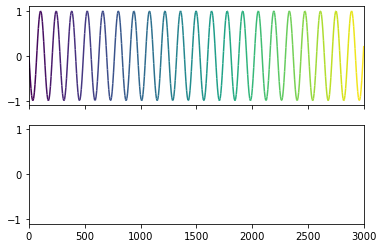

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3000, 500)
y = np.sin(x)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)

# Set the values used for colormapping
lc.set_array(x)
line = axs[0].add_collection(lc)

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(x)

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()